# Darts Framework Examples

In [1]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
torch.manual_seed(1)
np.random.seed(1)
import os

os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"


In [2]:
from darts import TimeSeries
from darts.utils.timeseries_generation import (
    gaussian_timeseries,
    linear_timeseries,
    sine_timeseries,
)

from darts.models import (
    RNNModel,
    TCNModel,
    TransformerModel,
    NBEATSModel,
    BlockRNNModel,
    VARIMA,
)
from darts.metrics import mape, smape, mae
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.datasets import AirPassengersDataset, MonthlyMilkDataset, ElectricityDataset


The `LightGBM` module could not be imported. To enable LightGBM support in Darts, follow the detailed instructions in the installation guide: https://github.com/unit8co/darts/blob/master/INSTALL.md
The `Prophet` module could not be imported. To enable Prophet support in Darts, follow the detailed instructions in the installation guide: https://github.com/unit8co/darts/blob/master/INSTALL.md
The `CatBoost` module could not be imported. To enable CatBoost support in Darts, follow the detailed instructions in the installation guide: https://github.com/unit8co/darts/blob/master/INSTALL.md


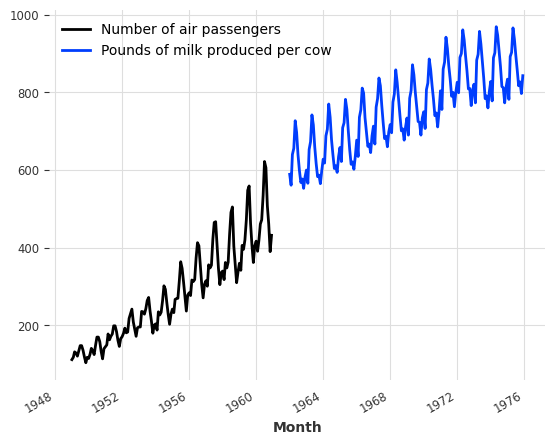

In [3]:
series_air = AirPassengersDataset().load()
series_milk = MonthlyMilkDataset().load()

series_air.plot(label="Number of air passengers")
series_milk.plot(label="Pounds of milk produced per cow")
plt.legend();

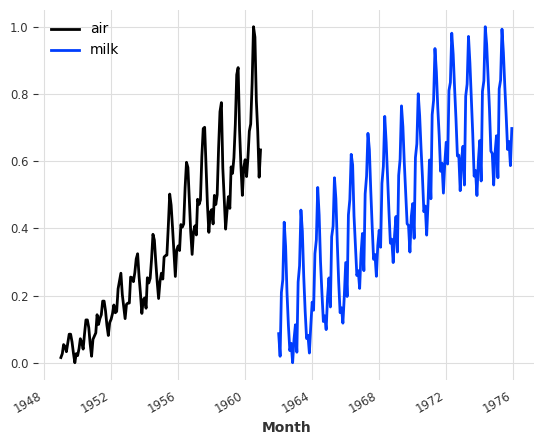

In [4]:
scaler_air, scaler_milk = Scaler(), Scaler()
series_air_scaled = scaler_air.fit_transform(series_air).astype(np.float32)
series_milk_scaled = scaler_milk.fit_transform(series_milk).astype(np.float32)

series_air_scaled.plot(label="air")
series_milk_scaled.plot(label="milk")
plt.legend();

In [5]:
train_air, val_air = series_air_scaled[:-36], series_air_scaled[-36:]
train_milk, val_milk = series_milk_scaled[:-36], series_milk_scaled[-36:]

In [6]:
train_air.dtype

dtype('float32')

In [7]:
model_air = NBEATSModel(
    input_chunk_length=24, output_chunk_length=12, n_epochs=100, random_state=0
)


In [8]:
model_air.fit(train_air, verbose=True);

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 6.2 M 
---------------------------------------------------
6.2 M     Trainable params
1.4 K     Non-trainable params
6.2 M     Total params
24.787    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

MAPE = 10.77%


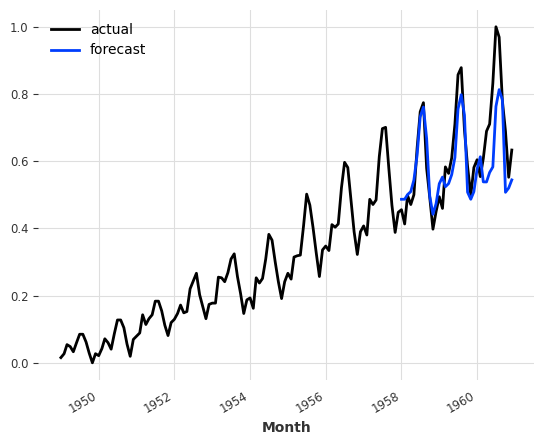

In [9]:
pred = model_air.predict(n=36)

series_air_scaled.plot(label="actual")
pred.plot(label="forecast")
plt.legend()
print("MAPE = {:.2f}%".format(mape(series_air_scaled, pred)))

In [10]:
model_air_milk = NBEATSModel(
    input_chunk_length=24, output_chunk_length=12, n_epochs=50, random_state=0
)

In [11]:
model_air_milk.fit([train_air, train_milk], verbose=True);

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 6.2 M 
---------------------------------------------------
6.2 M     Trainable params
1.4 K     Non-trainable params
6.2 M     Total params
24.787    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

MAPE = 13.98%


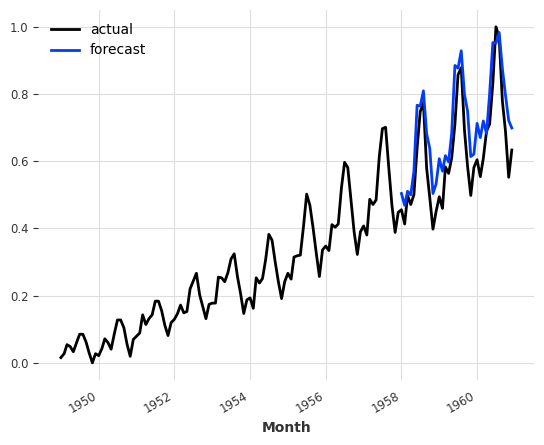

In [12]:
pred = model_air_milk.predict(n=36, series=train_air)

series_air_scaled.plot(label="actual")
pred.plot(label="forecast")
plt.legend()
print("MAPE = {:.2f}%".format(mape(series_air_scaled, pred)))

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

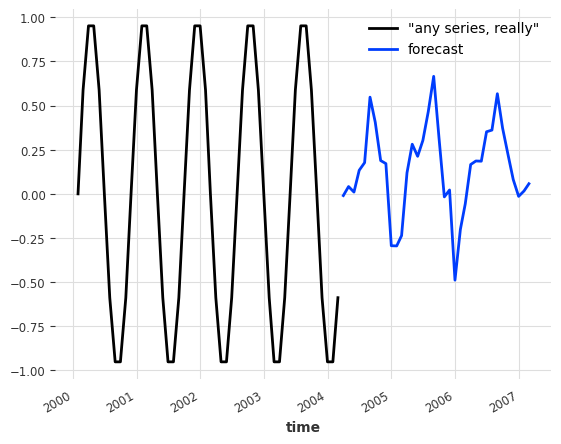

In [13]:
any_series = sine_timeseries(length=50, freq="M").astype(np.float32)
pred = model_air_milk.predict(n=36, series=any_series)

any_series.plot(label='"any series, really"')
pred.plot(label="forecast")
plt.legend();

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

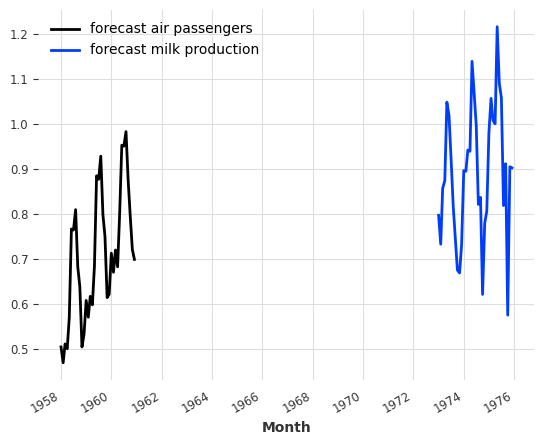

In [14]:
pred_list = model_air_milk.predict(n=36, series=[train_air, train_milk])
for series, label in zip(pred_list, ["air passengers", "milk production"]):
    series.plot(label=f"forecast {label}")
plt.legend();

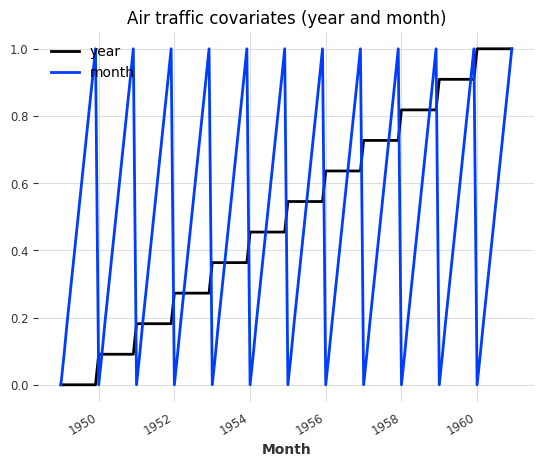

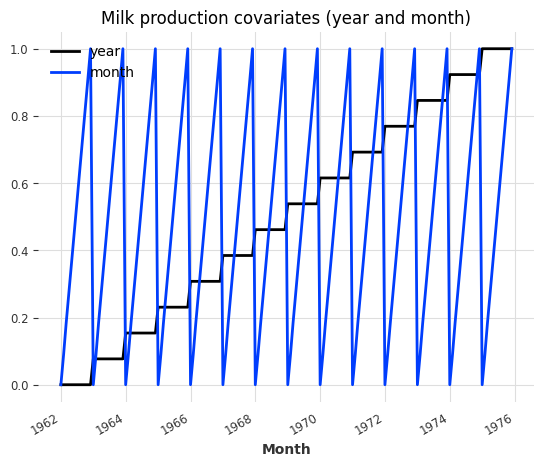

In [18]:
# build year and month series:
air_year = datetime_attribute_timeseries(series_air_scaled, attribute="year")
air_month = datetime_attribute_timeseries(series_air_scaled, attribute="month")

milk_year = datetime_attribute_timeseries(series_milk_scaled, attribute="year")
milk_month = datetime_attribute_timeseries(series_milk_scaled, attribute="month")

# stack year and month to obtain series of 2 dimensions (year and month):
air_covariates = air_year.stack(air_month)
milk_covariates = milk_year.stack(milk_month)

# scale them between 0 and 1:
scaler_dt_air = Scaler()
air_covariates = scaler_dt_air.fit_transform(air_covariates).astype(np.float32)

scaler_dt_milk = Scaler()
milk_covariates = scaler_dt_milk.fit_transform(milk_covariates).astype(np.float32)

# split in train/validation sets:
air_train_covariates, air_val_covariates = air_covariates[:-36], air_covariates[-36:]
milk_train_covariates, milk_val_covariates = (
    milk_covariates[:-36],
    milk_covariates[-36:],
)

# plot the covariates:
plt.figure()
air_covariates.plot()
plt.title("Air traffic covariates (year and month)")

plt.figure()
milk_covariates.plot()
plt.title("Milk production covariates (year and month)");

In [19]:
model_pastcov = BlockRNNModel(
    model="LSTM",
    input_chunk_length=24,
    output_chunk_length=12,
    n_epochs=100,
    random_state=0,
)

In [20]:
model_pastcov.fit(
    series=[train_air, train_milk],
    past_covariates=[air_train_covariates, milk_train_covariates],
    verbose=False,
);

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


ReferenceError: weakly-referenced object no longer exists

In [21]:
model_futcov = RNNModel(
    model="LSTM",
    hidden_dim=20,
    batch_size=8,
    n_epochs=100,
    random_state=0,
    training_length=36,
    input_chunk_length=24,
    force_reset=True,
)

model_futcov.fit(
    series=[train_air, train_milk],
    future_covariates=[air_train_covariates, milk_train_covariates],
    verbose=False,
);


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


ReferenceError: weakly-referenced object no longer exists

In [22]:
pred_cov = model_pastcov.predict(n=36, series=train_air, past_covariates=air_covariates)

series_air_scaled.plot(label="actual")
pred_cov.plot(label="forecast")
plt.legend();

AttributeError: 'NoneType' object has no attribute 'set_predict_parameters'

In [23]:
backtest_pastcov = model_pastcov.historical_forecasts(
    series_air_scaled,
    past_covariates=air_covariates,
    start=0.6,
    forecast_horizon=12,
    stride=1,
    retrain=False,
)

print(
    "MAPE (BlockRNNModel with past covariates) = {:.2f}%".format(
        mape(series_air_scaled, backtest_pastcov)
    )
)

backtest_futcov = model_futcov.historical_forecasts(
    series_air_scaled,
    future_covariates=air_covariates,
    start=0.6,
    forecast_horizon=12,
    stride=1,
    retrain=False,
)

print(
    "MAPE (RNNModel with future covariates) = {:.2f}%".format(
        mape(series_air_scaled, backtest_futcov)
    )
)

AttributeError: 'NoneType' object has no attribute 'set_predict_parameters'

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))
series_air_scaled.plot(label="actual", ax=axs[0])
backtest_pastcov.plot(label="forecast BlockRNN", ax=axs[0])
axs[0].legend()
series_air_scaled.plot(label="actual", ax=axs[1])
backtest_futcov.plot(label="forecast RNN", ax=axs[1], color="darkviolet")
axs[1].legend()
plt.show()

In [ ]:
multi_serie_elec = ElectricityDataset().load()

In [ ]:
# retaining only three components in different ranges
retained_components = ["MT_002", "MT_008", "MT_009"]
multi_serie_elec = multi_serie_elec[retained_components]
# resampling the multivariate time serie
multi_serie_elec = multi_serie_elec.resample(freq="1H")
# keep the values for the last 5 days
multi_serie_elec = multi_serie_elec[-168:]

In [ ]:
multi_serie_elec.plot()
plt.show()


In [ ]:
# split in train/validation sets
training_set, validation_set = multi_serie_elec[:-24], multi_serie_elec[-24:]

# define a scaler, by default, normalize each component between 0 and 1
scaler_dataset = Scaler()
# scaler is fit on training set only to avoid leakage
training_scaled = scaler_dataset.fit_transform(training_set)
validation_scaled = scaler_dataset.transform(validation_set)


def fit_and_pred(model, training, validation):
    model.fit(training)
    forecast = model.predict(len(validation))
    return forecast

In [ ]:
model_VARIMA = VARIMA(p=12, d=0, q=0, trend="n")

model_GRU = RNNModel(
    input_chunk_length=24,
    model="LSTM",
    hidden_dim=25,
    n_rnn_layers=3,
    training_length=36,
    n_epochs=200,
)

# training and prediction with the VARIMA model
forecast_VARIMA = fit_and_pred(model_VARIMA, training_scaled, validation_scaled)
print("MAE (VARIMA) = {:.2f}".format(mae(validation_scaled, forecast_VARIMA)))

# training and prediction with the RNN model
forecast_RNN = fit_and_pred(model_GRU, training_scaled, validation_scaled)
print("MAE (RNN) = {:.2f}".format(mae(validation_scaled, forecast_RNN)))

In [ ]:
forecast_VARIMA = scaler_dataset.inverse_transform(forecast_VARIMA)
forecast_RNN = scaler_dataset.inverse_transform(forecast_RNN)

labels = [f"forecast {component}" for component in retained_components]
fig, axs = plt.subplots(1, 2, figsize=(14, 6))
validation_set.plot(ax=axs[0])
forecast_VARIMA.plot(label=labels, ax=axs[0])
axs[0].set_ylim(0, 500)
axs[0].set_title("VARIMA model forecast")
axs[0].legend(loc="upper left")
validation_set.plot(ax=axs[1])
forecast_RNN.plot(label=labels, ax=axs[1])
axs[1].set_ylim(0, 500)
axs[1].set_title("RNN model forecast")
axs[1].legend(loc="upper left")
plt.show()

